# Home Automation Project

## Lights

The intensity of lights is dependent on the daylight.
The lights would get turned OFF gradually before sunrise, and they would get turned ON gradually before sunset.

In [6]:
from astral import LocationInfo
import pytz
from astral.geocoder import database, lookup

# Set up location information
tz_IND = pytz.timezone('Asia/Kolkata')
tz_LA = pytz.timezone('America/Los_Angeles')
# city = LocationInfo("Pune", "India", "Asia/Kolkata", 18.493255, 73.827113)
city = LocationInfo("Costa Mesa", "USA", "America/Los_Angeles", 33.692572, -117.878945)
# time_zone = lookup("Mumbai", database()).timezone
time_zone = lookup("Los_Angeles", database()).timezone
# tz = tz_IND
tz = tz_LA

# Define time_zone variable
time_zone = None

# Display location information
print((
    f"Information for {city.name}/{city.region}\n"
    f"Timezone: {city.timezone}\n"
    f"Latitude: {city.latitude:.02f}; Longitude: {city.longitude:.02f}\n"
))

Information for Costa Mesa/USA
Timezone: America/Los_Angeles
Latitude: 33.69; Longitude: -117.88



## Philips Hue

In [9]:
from apscheduler.schedulers.blocking import BlockingScheduler
import json
import requests
import urllib3
from astral.sun import sun
import time
from datetime import datetime, date, timedelta
from colour import Color

urllib3.disable_warnings()

hue_bridge_ip = '192.168.50.234'
user = 'kYezkr7YNGozEVSHkfneoHx3gO44ff8Ns0Qn9eKi'

s = sun(city.observer, tzinfo=time_zone)
sunrise = s['sunrise'].time()
sunset = s['sunset'].time()

data = None
hue_bridge_connection_error = False

def time_to_sunset_or_sunrise():
    global sunrise, sunset, data, hue_bridge_connection_error
    # Get current time
    now = datetime.now(tz)
    # print(f'Current time: {now.time()}')

    # Get time remaining for sunset and sunrise, and set intensity of light accordingly
    one_hour = timedelta(hours=1)
    one_minute = timedelta(minutes=1)
    zero_seconds = timedelta(seconds=0)

    # Check if time to sunset or sunrise is less than 1 hr, and set the brightness accordingly
    # Time to sunset
    time_to_sunset = datetime.combine(date.today(), sunset) - datetime.combine(date.today(), now.time())
    if time_to_sunset < zero_seconds:
        time_to_sunset = datetime.combine((date.today()+timedelta(days=1)), sunset) - datetime.combine(date.today(), now.time())
    if time_to_sunset < one_hour and time_to_sunset >= zero_seconds: # Less than 1 hr remaining for sunset
        # Calculate brightness of light in range 0-254
        brightness = ((one_hour - time_to_sunset)/one_minute)*254/60
        brightness = int(brightness)
        # print(f'Brightness: {brightness}')
        time_to_sunset_less_than_1hr = True
    else:
        time_to_sunset_less_than_1hr = False

    # Time to sunrise
    time_to_sunrise = datetime.combine(date.today(), sunrise) - datetime.combine(date.today(), now.time())
    if time_to_sunrise < zero_seconds:
        time_to_sunrise = datetime.combine((date.today()+timedelta(days=1)), sunrise) - datetime.combine(date.today(), now.time())
    if time_to_sunrise < one_hour and time_to_sunrise >= zero_seconds: # Less than 1 hr remaining for sunrise
        # Calculate brightness of light in range 0-254
        brightness = (time_to_sunrise/one_minute)*254/60
        # convert brightness to int
        brightness = int(brightness)
        # print(f'Brightness: {brightness}')
        time_to_sunrise_less_than_1hr = True
    else:
        time_to_sunrise_less_than_1hr = False

    # Get the hue of the input color name
    # user_color = input("Enter color name: ")
    user_color = "white"
    color = Color(user_color)
    sat = color.saturation
    hue = color.hue
    hue = int(hue*65535) # Hue is in range 0-1, convert it to 0-65535
    sat = int(sat*254)  # Saturation is in range 0-1, convert it to 0-254
    if hue_bridge_connection_error == False:
        light_id = list(data.keys())        # Get the light ids
        # Turn on the lights
        for light in light_id:
            if(data[light]['state']['reachable'] == True and data[light]['state']['on'] == False):
                url = 'https://'+hue_bridge_ip+'/api/'+user+'/lights/'+light+'/state'
                headers = {
                    'content-type': "application/json",
                    'cache-control': "no-cache"
                }
                sending_data ={'on': True}
                try:
                    response = requests.put(url, headers=headers, data=json.dumps(sending_data), verify=False)
                except requests.exceptions.Timeout:
                    hue_bridge_connection_error = True
                    print("TimeoutError: Could not turn ON the light.\n")
        # loop through all lights if time to sunrise or sunset is less than 1 hr and set the brightness accordingly
        if time_to_sunrise_less_than_1hr == True or time_to_sunset_less_than_1hr == True:
            for light in light_id:
                if(data[light]['state']['reachable'] == True):
                    url = 'https://'+hue_bridge_ip+'/api/'+user+'/lights/'+light+'/state'
                    headers = {
                        'content-type': "application/json",
                        'cache-control': "no-cache"
                    }
                    sending_data ={'sat': sat, 'bri': brightness, 'hue': hue}
                    try:
                        response = requests.put(url, headers=headers, data=json.dumps(sending_data), verify=False)
                        print("Setting the brightness to: ", brightness, ".\n")
                    except requests.exceptions.Timeout:
                        hue_bridge_connection_error = True
                        print("TimeoutError: Could not set the brightness.\n")  
    if hue_bridge_connection_error == True:
        try:
            url = 'https://'+hue_bridge_ip+'/api/'+user+'/lights'
            response = requests.get(url, verify=False)
            data = json.loads(response.text)    # Convert json data to python dictionary
            light_id = list(data.keys())        # Get the light ids
            hue_bridge_connection_error = False
        except:
            hue_bridge_connection_error = True
            print("Hue Bridge Disconnected")

def sunrise_sunset_time():
    global sunrise, sunset, data, hue_bridge_connection_error
    url = 'https://'+hue_bridge_ip+'/api/'+user+'/lights'
    try:
        response = requests.get(url, verify=False)
        data = json.loads(response.text)        # Convert json data to python dictionary
        # print(json.dumps(data, indent=4))     # Pretty print json data
    except:
        hue_bridge_connection_error = True
        print("Error in connecting to the Hue Bridge")

    # Get sunrise and sunset information
    s = sun(city.observer, tzinfo=time_zone)
    print((
        f'Sunrise: {s["sunrise"].time()}\n'
        f'Sunset:  {s["sunset"].time()}\n'
    ))
    sunrise = s['sunrise'].time()
    sunset = s['sunset'].time()

sunrise_sunset_time()
scheduler = BlockingScheduler()
scheduler.add_job(sunrise_sunset_time, 'interval', hours=24)        # Calculate sunrise and sunset times once a day
scheduler.add_job(time_to_sunset_or_sunrise, 'interval', minutes=1) # Calculate time to sunset or sunrise every minute and set the brightness of light accordingly
# scheduler.start()

Error in connecting to the Hue Bridge
Sunrise: 06:11:26.411096
Sunset:  19:41:15.910239



<Job (id=9733da6a06c64cf39627a5c8e95450cb name=time_to_sunset_or_sunrise)>

### Motion detected lights

There would be a LED light strip for each room which would light up subtlely and will be triggered by motion.

1. Routines:
    * If time is more than sunset and less than sunrise, then trigger lights that leads to the bathroom. These lights would be on the floor level.
    * A device (proxi sensor) to keep track of number of people in the house and in the room.
    

## Camera

This would keep track of number of people in the house.


ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

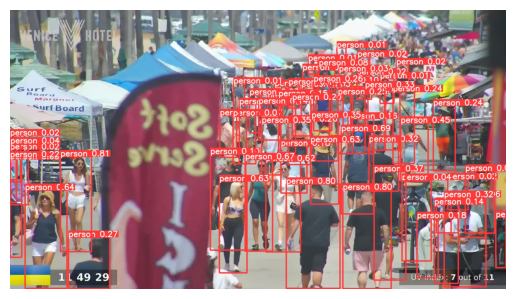

In [10]:
# Delete all files in the output folder
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt

folder = '/home/vader/SourceCode/home-automation/output'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

!rm /home/vader/SourceCode/home-automation/input/venice.jpg

!ffmpeg -i "$(yt-dlp -g 3LXQWU67Ufk | head -n 1)" -vframes 1 /home/vader/SourceCode/home-automation/input/venice.jpg

!python /home/vader/SourceCode/yolov9/detect.py --weights /home/vader/SourceCode/yolov9/yolov9-e.pt --conf 0.01 --source /home/vader/SourceCode/home-automation/input/venice.jpg --device 0 --name gp1 --save-txt --save-conf --exist-ok --project /home/vader/SourceCode/home-automation/output --class 0

# Count the number of lines in the venice.txt file
folder = '/home/vader/SourceCode/home-automation/output/gp1/labels'
filename = 'venice.txt'
file_path = os.path.join(folder, filename)
if os.path.isfile(file_path):
    with open(file_path, 'r') as file:
        line_count = sum(1 for line in file)
        print(f"There are {line_count} people in the frame.")

# Display the output image
output_image_path = '/home/vader/SourceCode/home-automation/output/gp1/venice.jpg'
output_image = Image.open(output_image_path)
plt.imshow(output_image)
plt.axis('off')
plt.show()

## House AI

It would be updated with the number of people in the house, and in which room they are in. 

There would be microphones/with camera in each room listening to the commands And sending them to the central server.

The facial recognition will update number of persons in each room. (no facial recognition (for now)).

The voice would not have a recognition system (for now)

